In [1]:
#  _____      _                  _   
# | ____|_  _| |_ _ __ __ _  ___| |_ 
# |  _| \ \/ / __| '__/ _` |/ __| __|
# | |___ >  <| |_| | | (_| | (__| |_ 
# |_____/_/\_\\__|_|  \__,_|\___|\__|
# Make cool text with Figlet! http://www.figlet.org/

import sqlite3

# Download database.sqlite from https://www.kaggle.com/laudanum/footballdelphi
connection = sqlite3.Connection('database.sqlite')
cursor = connection.cursor()

# Instead of using a DataFrame (overkill) to get all of our teams from `Unique_Teams`
# just build a list of the team names as strings using a list comprehension. We'll
# use this later to build dictionaries and results for each team.
teams = [record[0] for record in cursor.execute('SELECT TeamName FROM Unique_Teams').fetchall()]

https://en.wikipedia.org/wiki/View_(SQL)

I found serveral views on the sources SQLite database, including FlatView_Advanced and decided to use them. FlatView_Advanced is defined as:

```sql
CREATE VIEW FlatView_Advanced AS SELECT Match_ID,
    Unique_Team_ID,
    Teams.TeamName AS 'Unique_Team',
    Div,
    Teams.Season,
    Date,
    HomeTeam,
    AwayTeam,
    FTHG,
    FTAG,
    FTR,
    KaderHome,
    AvgAgeHome,
    ForeignPlayersHome,
    OverallMarketValueHome,
    AvgMarketValueHome,
    StadiumCapacity
FROM FlatView_Chrono_TeamOrder_Reduced
JOIN Teams ON (FlatView_Chrono_TeamOrder_Reduced.Unique_Team = Teams.TeamName)
    AND (FlatView_Chrono_TeamOrder_Reduced.Season = Teams.Season)
ORDER BY Unique_Team_ID ASC, Date ASC
```

Which also uses the view FlatView_Chrono_TeamOrder_Reduced:

```sql
CREATE VIEW FlatView_Chrono_TeamOrder_Reduced
AS SELECT * ,Unique_Teams.TeamName as "Unique_Team"
FROM Teams_in_Matches
  JOIN Unique_Teams
  JOIN Matches
    ON (Teams_in_Matches.Match_ID = Matches.Match_ID)
      AND (Teams_in_Matches.Unique_Team_ID = Unique_Teams.Unique_Team_ID)
ORDER BY Teams_in_Matches.Unique_Team_ID, date(Date)
```

In [2]:
import pandas as pd

# Extract all of the records from the FlatView_Advanced view into a DataFrame.
# Only get the fields we'll need later and only records where the season is '2011'
FlatView_Advanced = pd.DataFrame(cursor.execute("SELECT Date, HomeTeam, AwayTeam, FTHG, FTAG, FTR FROM FlatView_Advanced WHERE Season = '2011'").fetchall())
FlatView_Advanced.columns = [x[0] for x in cursor.description]

# Get a list of unique days where games were played from FlatView_Advanced in the 2011 season for later memoization of rainy days.
days = [record[0] for record in cursor.execute("SELECT DISTINCT date FROM FlatView_Advanced WHERE Season = '2011'").fetchall()]

In [3]:
#  _____                     __
# |_   _| __ __ _ _ __  ___ / _| ___  _ __ _ __ ___
#   | || '__/ _` | '_ \/ __| |_ / _ \| '__| '_ ` _ \ 
#   | || | | (_| | | | \__ \  _| (_) | |  | | | | | |
#   |_||_|  \__,_|_| |_|___/_|  \___/|_|  |_| |_| |_|
# 

import requests

from datetime import datetime
import pytz

# Setup a class to initialize the parameters for the Dark Sky API calls so that it can be reused.

class WeatherGetter():
    
    def __init__(self, api_key, latitude, longitude):
        self.api_key = api_key
        self.latitude = latitude
        self.longitude = longitude
    
    def rain(self, timestamp):
        # Format the date and time from timestamp as Dark Sky expects it.
        dark_sky_datetime = timestamp.strftime("%Y-%m-%dT%H%:%M:%S%z")

        # See: https://darksky.net/dev/docs#time-machine-request
        # example URL: https://api.darksky.net/forecast/0123456789abcdef9876543210fedcba/42.3601,-71.0589,255657600?
        request_url = f"https://api.darksky.net/forecast/{self.api_key}/{self.latitude},{self.longitude},{dark_sky_datetime}"
        
        # Return the value inside of the Dark Sky JSON reponse that indicates wether it rained on the day in question
        return requests.get(request_url).json()['daily']['data'][0]['icon'] == 'rain'

In [4]:
weather_getter = WeatherGetter("5c319c63fd893630e1e0c8d59f2e8856", "52.516667", "13.388889")

# Memoization: https://en.wikipedia.org/wiki/Memoization
# Multiple games can be played on the same day. And two teams participate in a
# single game.
# Instead of talking to Dark Sky's API for each instance, record wether it
# rained or not for every game day represented in the database (for the 2011
# season) and look it up later.

rainy_days = {}

for day in days:
    # Parse the date from the record as a datetime object
    day_datetime = datetime.strptime(day, "%Y-%m-%d")
    # Set the timezone on the datetime object to Berlin's timezone
    day_datetime = day_datetime.replace(tzinfo=pytz.timezone('Europe/Berlin'))
    
    # Add to the dictionary of game days. Use the date string as the key and set the value
    # to wether it rained or not as a boolean returned from WeatherGetter.rain()
    rainy_days[day] = weather_getter.rain(day_datetime)

In [5]:
# This is where we get rid if the ambiguity around home and away that is
# represented in the SQLite database.

# Create a list of dictionaries that contains the team name and a DataFrame for
# that team that contains all of its games, the number of goals in those games,
# wether it was a win, and if it rained.

team_games = []

for team in teams: 
    
    games = []
    
    # Teams are never both Home and Away so we can go over both to get all of their games
    for home_game_index in FlatView_Advanced.index[FlatView_Advanced.HomeTeam == (team)]:
        date = FlatView_Advanced.iloc[home_game_index].Date
        games.append({
            "date": date,
            # Save he number of goals the team made in the game
            "goals": FlatView_Advanced.iloc[home_game_index].FTHG,
            # If the team won, set 'win' to 1, otherwise (a loss) set it to 0
            "win": 1 if FlatView_Advanced.iloc[home_game_index].FTR == 'H' else 0,
            # Get wether it rained or not on this game day from the rainy_days dictionary
            "rain": rainy_days[date]
        })
        
    for away_game_index in FlatView_Advanced.index[FlatView_Advanced.AwayTeam == (team)]:
        games.append({
            "date": FlatView_Advanced.iloc[away_game_index].Date,
            "goals": FlatView_Advanced.iloc[away_game_index].FTAG,
            "win": 1 if FlatView_Advanced.iloc[away_game_index].FTR == 'A' else 0,
            "rain": rainy_days[date]
        })

    team_df = pd.DataFrame(games)
    
    if len(team_df.index.values) == 0:
        continue
    
    # Use the 'date' column as an index and coerce the string to a real timestamp
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
    pd.to_datetime(team_df['date'], format='%Y-%m-%d')
    team_df.set_index(team_df['date'], inplace=True)
    del team_df['date']

    # Our final datastructure is a list of dictionaries that contains the team's name and a
    # DataFrame of its games.
    team_games.append({'name': team, 'df': team_df})

/Users/georginasampson/.virtualenvs/georgina__dsc_mod_2/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


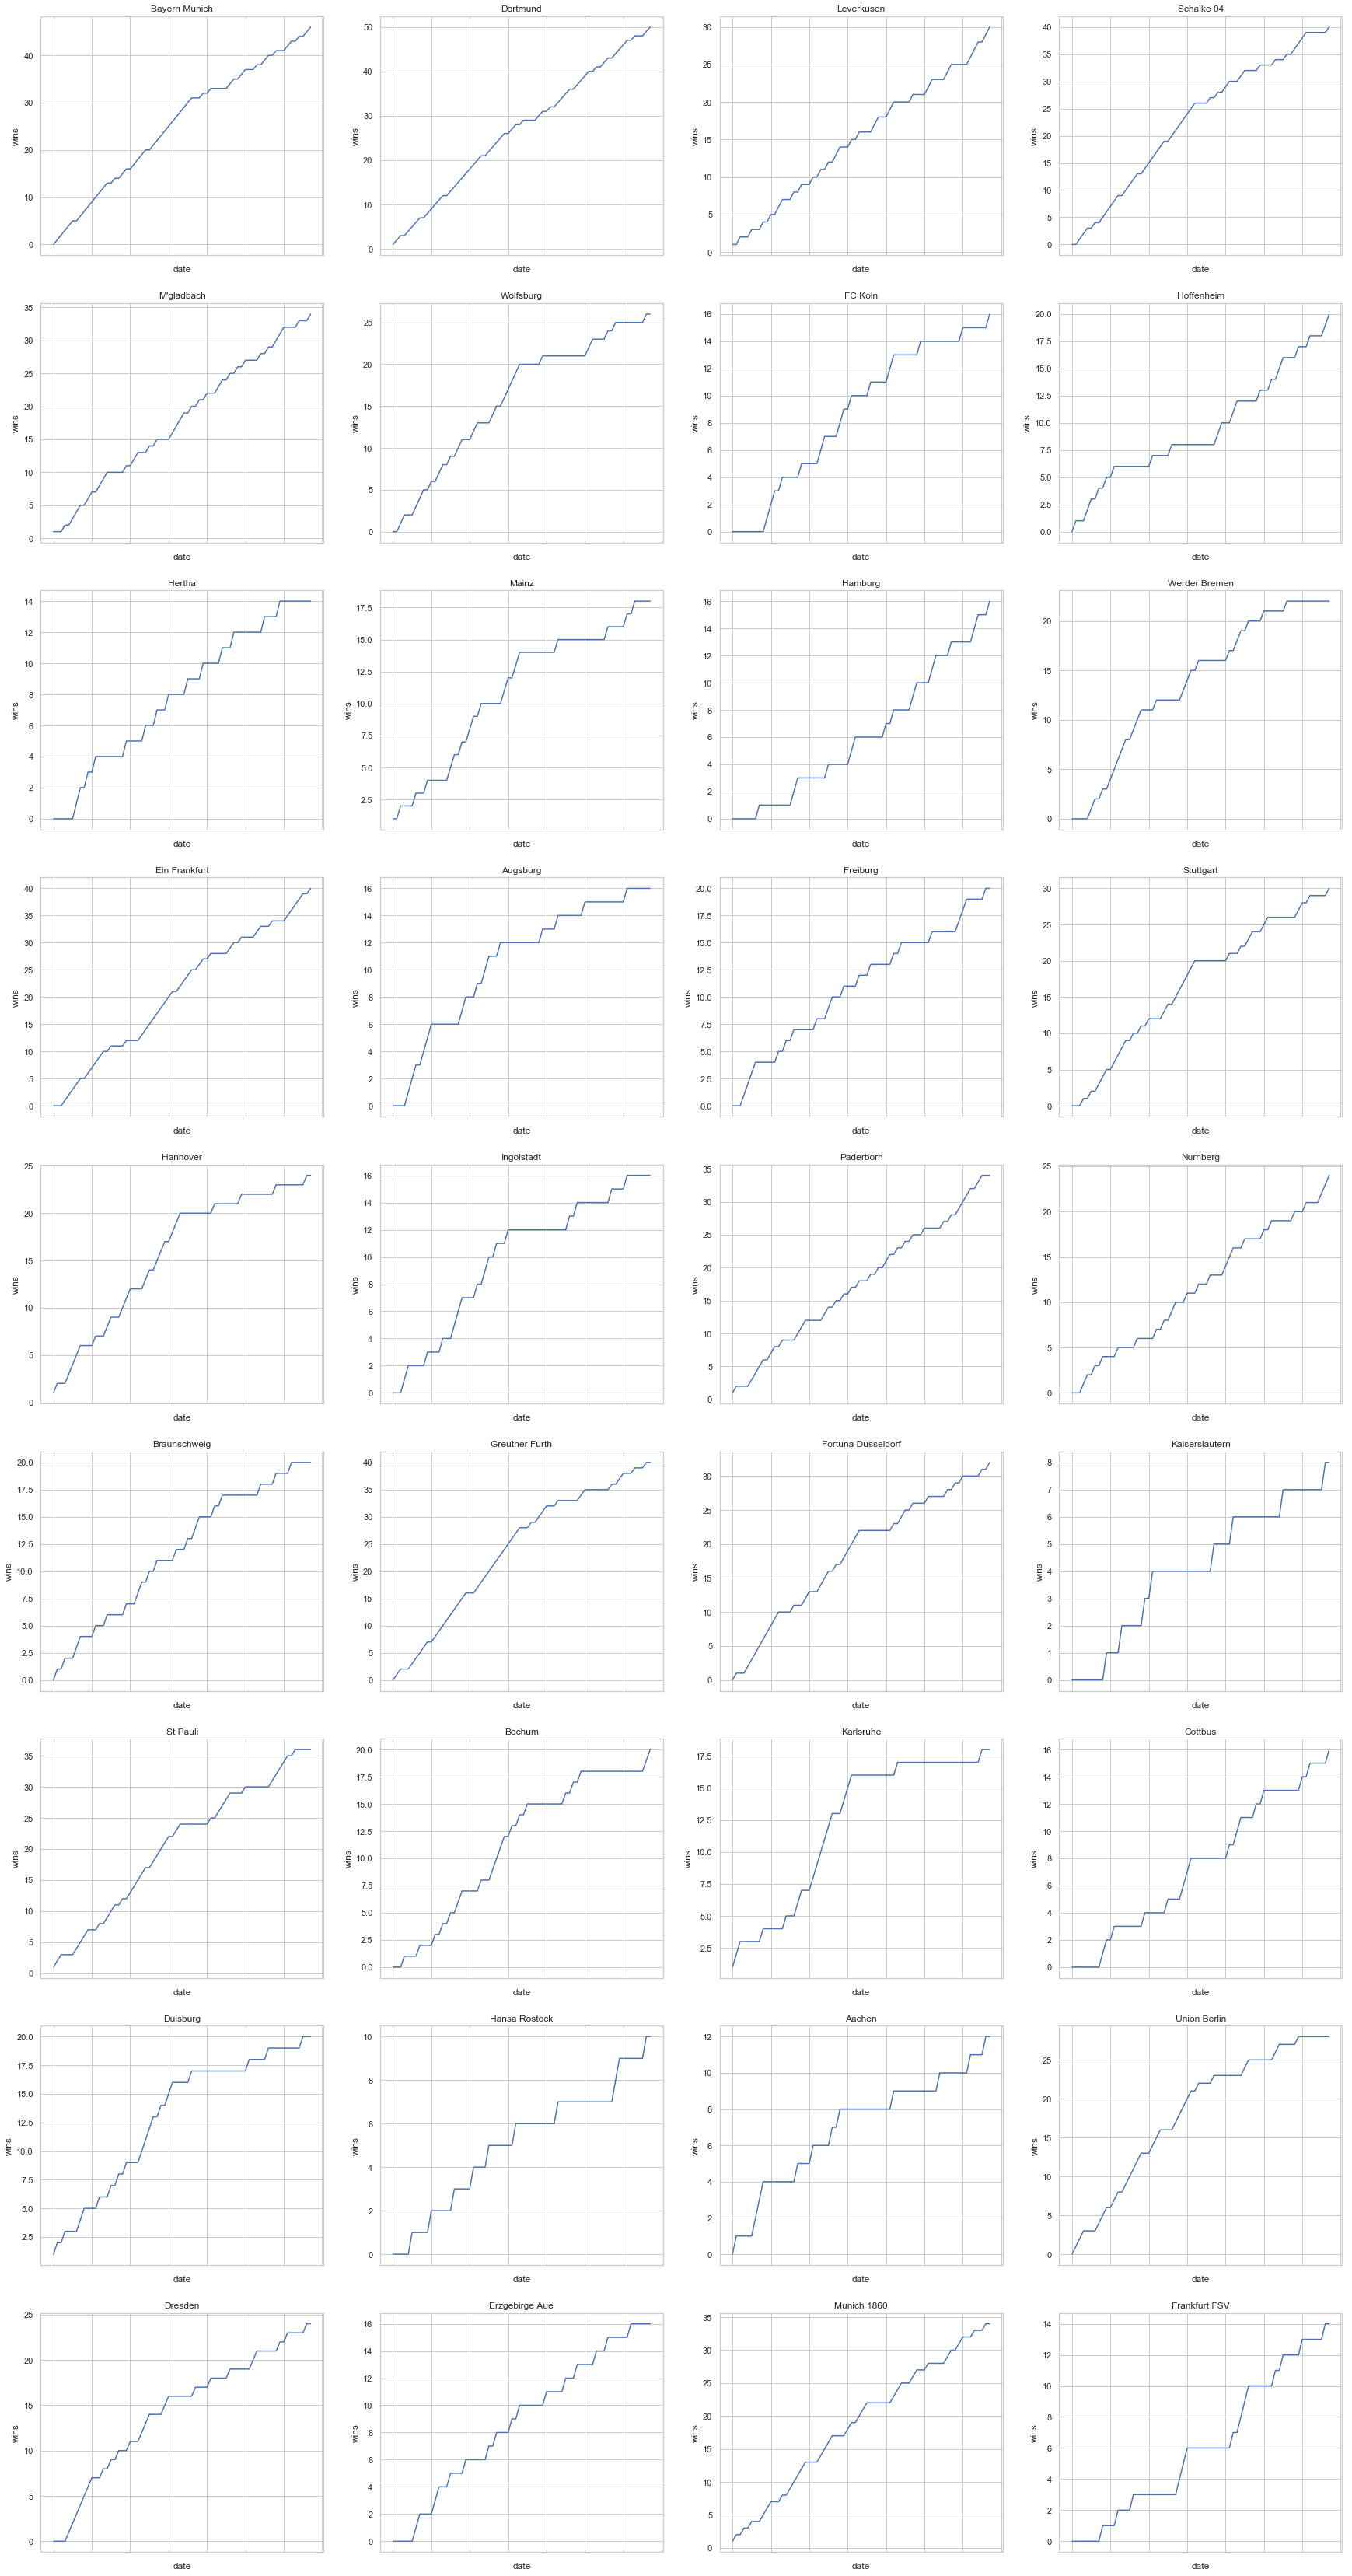

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
sns.set(style="whitegrid")

# Set up a grid of matplotlib plots
fig, axes = plt.subplots(nrows=9, ncols=4, sharex=False, sharey=False, figsize=(30,60))

# Iterate over both the axes from above and the team_games list
for ax, team_game in zip(axes.flat, team_games):
    team_name = team_game['name']
    df = team_game['df']
    df['win'].cumsum().plot(title=team_name, ax=ax)
    ax.set_ylabel('wins')
    ax.grid(True)

plt.show()

In [7]:
#  _                    _
# | |    ___   __ _  __| |
# | |   / _ \ / _` |/ _` |
# | |__| (_) | (_| | (_| |
# |_____\___/ \__,_|\__,_|

# https://pypi.org/project/pymongo/
import pymongo

In [9]:
# Before connecting, start MongoDB with:
#     brew services start mongodb
# Connect to MonogDB at localhost:27017
client = pymongo.MongoClient("localhost", 27017)

# Create a new database in MongoDB named 'football'
db = client.football

# Create a new collection on the MongoDB database named 'football_teams_collection'
football_teams_collection = db.teams

for team_game in team_games:
    df = team_game['df']
    
    # calculate the measurements needed for "rainy_wins_percentage" below
    rainy_games = df[df.rain == True]
    rainy_games_count = len(rainy_games.index)
    rainy_games_won_count = len(rainy_games[rainy_games.win == 1].index)
    
    # TODO(GS): Figure out how to save plots in MongoDB
    # fig, ax = plt.subplots(sharex=False, sharey=False, figsize=(30,10))
    # df['win'].cumsum().plot(title=team_name, ax=ax)
    # ax.set_ylabel('wins')
    
    #  _                            _              _   
    # (_)_ __ ___  _ __   ___  _ __| |_ __ _ _ __ | |_ 
    # | | '_ ` _ \| '_ \ / _ \| '__| __/ _` | '_ \| __|
    # | | | | | | | |_) | (_) | |  | || (_| | | | | |_ 
    # |_|_| |_| |_| .__/ \___/|_|   \__\__,_|_| |_|\__|
    #             |_|                                  
    # 
    # Insert our final record into MongoDB:
    football_teams_collection.insert_one(
        {"team_name": team_game['name'],
         "total_goals": int(df['goals'].sum()),
         "total_wins": int(df['win'][df['win'] == 1].count()),
         "rainy_wins_percentage": f"{rainy_games_won_count/rainy_games_count * 100}%",
         #"histogram": plt,
        }
    ).inserted_id
    
#football_teams_collection.create_index("x")

In [10]:
import pprint

# https://docs.python.org/3/library/pprint.html
pp = pprint.PrettyPrinter(indent=4)

for item in football_teams_collection.find():
    pp.pprint(item)

{   '_id': ObjectId('5d198661ace21f93b8c98198'),
    'rainy_wins_percentage': '75.0%',
    'team_name': 'Bayern Munich',
    'total_goals': 154,
    'total_wins': 46}
{   '_id': ObjectId('5d198661ace21f93b8c98199'),
    'rainy_wins_percentage': '80.0%',
    'team_name': 'Dortmund',
    'total_goals': 160,
    'total_wins': 50}
{   '_id': ObjectId('5d198661ace21f93b8c9819a'),
    'rainy_wins_percentage': '37.5%',
    'team_name': 'Leverkusen',
    'total_goals': 104,
    'total_wins': 30}
{   '_id': ObjectId('5d198661ace21f93b8c9819b'),
    'rainy_wins_percentage': '66.66666666666666%',
    'team_name': 'Schalke 04',
    'total_goals': 148,
    'total_wins': 40}
{   '_id': ObjectId('5d198661ace21f93b8c9819c'),
    'rainy_wins_percentage': '52.17391304347826%',
    'team_name': "M'gladbach",
    'total_goals': 98,
    'total_wins': 34}
{   '_id': ObjectId('5d198661ace21f93b8c9819d'),
    'rainy_wins_percentage': '66.66666666666666%',
    'team_name': 'Wolfsburg',
    'total_goals': 94,
 